<a href="https://colab.research.google.com/github/ClarkQuinn/Brain-Tumor-Detection/blob/main/3d_segmentation/brats_segmentation_3d.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Setup environment

In [3]:
!python -c "import monai" || pip install -q "monai-weekly[nibabel, tqdm]"
!python -c "import matplotlib" || pip install -q matplotlib
!python -c "import onnxruntime" || pip install -q onnxruntime
%matplotlib inline

Traceback (most recent call last):
  File "<string>", line 1, in <module>
ModuleNotFoundError: No module named 'monai'
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 81.3 MB/s eta 0:00:00
Traceback (most recent call last):
  File "<string>", line 1, in <module>
ModuleNotFoundError: No module named 'onnxruntime'
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.4/17.4 MB 128.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 8.0 MB/s eta 0:00:00


## Setup imports

In [4]:
import os
import shutil
import tempfile
import time
import matplotlib.pyplot as plt
from monai.apps import DecathlonDataset
from monai.config import print_config
from monai.data import DataLoader, decollate_batch
from monai.handlers.utils import from_engine
from monai.losses import DiceLoss
from monai.inferers import sliding_window_inference
from monai.metrics import DiceMetric
from monai.networks.nets import SegResNet
from monai.transforms import (
    Activations,
    Activationsd,
    AsDiscrete,
    AsDiscreted,
    Compose,
    Invertd,
    LoadImaged,
    MapTransform,
    NormalizeIntensityd,
    Orientationd,
    RandFlipd,
    RandScaleIntensityd,
    RandShiftIntensityd,
    RandSpatialCropd,
    Spacingd,
    EnsureTyped,
    EnsureChannelFirstd,
)
from monai.utils import set_determinism
import onnxruntime
from tqdm import tqdm

import torch

print_config()

<frozen importlib._bootstrap_external>:1301: FutureWarning: The cuda.cudart module is deprecated and will be removed in a future release, please switch to use the cuda.bindings.runtime module instead.


MONAI version: 1.6.dev2549
Numpy version: 2.0.2
Pytorch version: 2.9.0+cu126
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 5a9de6cc34f45d433f9503b8a12b698497db7d4e
MONAI __file__: /usr/local/lib/python3.12/dist-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
ITK version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 5.3.3
scikit-image version: 0.25.2
scipy version: 1.16.3
Pillow version: 11.3.0
Tensorboard version: 2.19.0
gdown version: 5.2.0
TorchVision version: 0.24.0+cu126
tqdm version: 4.67.1
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.9.5
pandas version: 2.2.2
einops version: 0.8.1
transformers version: 4.57.3
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.
clearml version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://monai.readthe

## Setup data directory

You can specify a directory with the `MONAI_DATA_DIRECTORY` environment variable.  
This allows you to save results and reuse downloads.  
If not specified a temporary directory will be used.

In [5]:
from google.colab import drive
drive.mount('/content/drive')

root_dir = "/content/drive/MyDrive/BraTS-MONAI"
os.makedirs(root_dir, exist_ok=True)
print(root_dir)

Mounted at /content/drive
/content/drive/MyDrive/BraTS-MONAI


## Set deterministic training for reproducibility

In [6]:
set_determinism(seed=63)

## Define a new transform to convert brain tumor labels

Here we convert the multi-classes labels into multi-labels segmentation task in One-Hot format.

In [7]:
class ConvertToMultiChannelBasedOnBratsClassesd(MapTransform):
    """
    Convert labels to multi channels based on brats classes:
    label 1 is the peritumoral edema
    label 2 is the GD-enhancing tumor
    label 3 is the necrotic and non-enhancing tumor core
    The possible classes are TC (Tumor core), WT (Whole tumor)
    and ET (Enhancing tumor).

    """

    def __call__(self, data):
        d = dict(data)
        for key in self.keys:
            result = []
            # merge label 2 and label 3 to construct TC
            result.append(torch.logical_or(d[key] == 2, d[key] == 3))
            # merge labels 1, 2 and 3 to construct WT
            result.append(torch.logical_or(torch.logical_or(d[key] == 2, d[key] == 3), d[key] == 1))
            # label 2 is ET
            result.append(d[key] == 2)
            d[key] = torch.stack(result, axis=0).float()
        return d

## Setup transforms for training and validation

In [8]:
train_transform = Compose(
    [
        # load 4 Nifti images and stack them together
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys="image"),
        EnsureTyped(keys=["image", "label"]),
        ConvertToMultiChannelBasedOnBratsClassesd(keys="label"),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(
            keys=["image", "label"],
            pixdim=(1.0, 1.0, 1.0),
            mode=("bilinear", "nearest"),
        ),
        RandSpatialCropd(keys=["image", "label"], roi_size=[224, 224, 144], random_size=False),
        RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=0),
        RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=1),
        RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=2),
        NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
        RandScaleIntensityd(keys="image", factors=0.1, prob=1.0),
        RandShiftIntensityd(keys="image", offsets=0.1, prob=1.0),
    ]
)
val_transform = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys="image"),
        EnsureTyped(keys=["image", "label"]),
        ConvertToMultiChannelBasedOnBratsClassesd(keys="label"),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(
            keys=["image", "label"],
            pixdim=(1.0, 1.0, 1.0),
            mode=("bilinear", "nearest"),
        ),
        NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
    ]
)

/usr/local/lib/python3.12/dist-packages/monai/utils/deprecate_utils.py:321: FutureWarning: monai.transforms.spatial.dictionary Orientationd.__init__:labels: Current default value of argument `labels=(('L', 'R'), ('P', 'A'), ('I', 'S'))` was changed in version None from `labels=(('L', 'R'), ('P', 'A'), ('I', 'S'))` to `labels=None`. Default value changed to None meaning that the transform now uses the 'space' of a meta-tensor, if applicable, to determine appropriate axis labels.
  warn_deprecated(argname, msg, warning_category)


## Quickly load data with DecathlonDataset

Here we use `DecathlonDataset` to automatically download and extract the dataset.
It inherits MONAI `CacheDataset`, if you want to use less memory, you can set `cache_num=N` to cache N items for training and use the default args to cache all the items for validation, it depends on your memory size.

In [9]:
root_dir

'/content/drive/MyDrive/BraTS-MONAI'

In [10]:
! cd $root_dir && ls

best_metric_model.onnx	     checkpoints
best_metric_model.onnx.data  Task01_BrainTumour


In [11]:
# here we don't cache any data in case out of memory issue
train_ds = DecathlonDataset(
    root_dir=root_dir,
    task="Task01_BrainTumour",
    transform=train_transform,
    section="training",
    download=True,
    cache_rate=0.0,
    num_workers=4,
)
train_loader = DataLoader(train_ds, batch_size=1, shuffle=True, num_workers=0)
val_ds = DecathlonDataset(
    root_dir=root_dir,
    task="Task01_BrainTumour",
    transform=val_transform,
    section="validation",
    download=False,
    cache_rate=0.0,
    num_workers=4,
)
val_loader = DataLoader(val_ds, batch_size=1, shuffle=False, num_workers=0)

Task01_BrainTumour.tar: 7.09GB [08:51, 14.3MB/s]                            


2025-12-13 04:14:59,675 - INFO - Downloaded: /content/drive/MyDrive/BraTS-MONAI/Task01_BrainTumour.tar
2025-12-13 04:17:20,633 - INFO - Verified 'Task01_BrainTumour.tar', md5: 240a19d752f0d9e9101544901065d872.
2025-12-13 04:17:20,644 - INFO - Non-empty folder exists in /content/drive/MyDrive/BraTS-MONAI/Task01_BrainTumour, skipped extracting.


## Check data shape and visualize

image shape: torch.Size([4, 240, 240, 155])


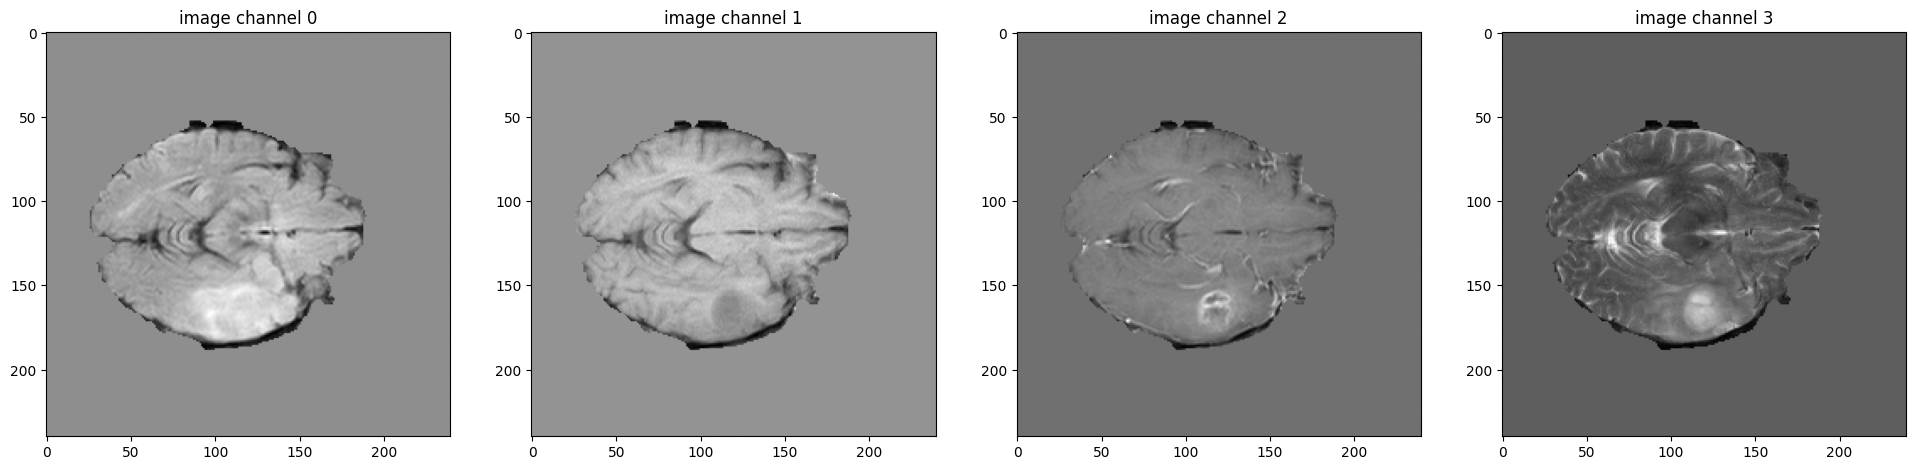

label shape: torch.Size([3, 240, 240, 155])


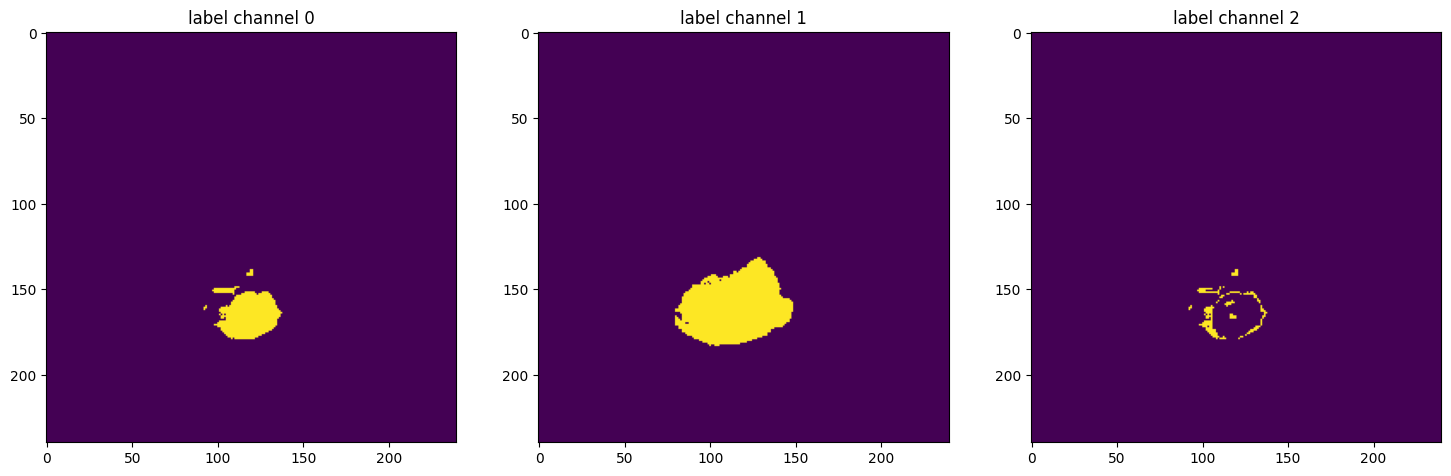

In [12]:
# pick one image from DecathlonDataset to visualize and check the 4 channels
val_data_example = val_ds[2]
print(f"image shape: {val_data_example['image'].shape}")
plt.figure("image", (24, 6))
for i in range(4):
    plt.subplot(1, 4, i + 1)
    plt.title(f"image channel {i}")
    plt.imshow(val_data_example["image"][i, :, :, 60].detach().cpu(), cmap="gray")
plt.show()
# also visualize the 3 channels label corresponding to this image
print(f"label shape: {val_data_example['label'].shape}")
plt.figure("label", (18, 6))
for i in range(3):
    plt.subplot(1, 3, i + 1)
    plt.title(f"label channel {i}")
    plt.imshow(val_data_example["label"][i, :, :, 60].detach().cpu())
plt.show()

## Create Model, Loss, Optimizer

In [13]:
device = torch.device("cuda:0")

In [14]:
import os
import time
from tqdm import tqdm

import torch

# Device selection: support CUDA, or CPU
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using CUDA device")
else:
    device = torch.device("cpu")
    print("Using CPU device")

from monai.networks.nets import UNet
from monai.losses import DiceLoss
from monai.metrics import DiceMetric
from monai.transforms import Compose, Activations, AsDiscrete
from monai.inferers import sliding_window_inference
from monai.data.utils import decollate_batch

# ------------------------------------------------------------------
# Basic config
# ------------------------------------------------------------------
max_epochs = 100
val_interval = 1
VAL_AMP = torch.cuda.is_available()  # use AMP only for CUDA

# ------------------------------------------------------------------
# Model
# ------------------------------------------------------------------
model = UNet(
    spatial_dims=3,
    in_channels=4,
    out_channels=3,               # TC, WT, ET
    channels=(16, 32, 64, 128, 256),
    strides=(2, 2, 2, 2),
    num_res_units=2,
    norm="instance",
    dropout=0.2,
).to(device)

# ------------------------------------------------------------------
# Loss, optimizer, scheduler
# ------------------------------------------------------------------
loss_function = DiceLoss(
    smooth_nr=0,
    smooth_dr=1e-5,
    squared_pred=True,
    to_onehot_y=False,            # labels already multi-channel (TC, WT, ET)
    sigmoid=True,                 # multi-label, not softmax
)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)

lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer,
    T_max=max_epochs,
)

# ------------------------------------------------------------------
# Metrics
#   - use MONAI for global mean Dice
#   - per-class Dice will be computed manually
# ------------------------------------------------------------------
dice_metric = DiceMetric(include_background=True, reduction="mean")

# ------------------------------------------------------------------
# Post-processing
# ------------------------------------------------------------------
post_trans = Compose([
    Activations(sigmoid=True),
    AsDiscrete(threshold=0.5),
])

# ------------------------------------------------------------------
# Sliding-window inference with AMP (only for CUDA)
# ------------------------------------------------------------------
def inference(inputs: torch.Tensor) -> torch.Tensor:
    def _compute(x: torch.Tensor) -> torch.Tensor:
        return sliding_window_inference(
            inputs=x,
            roi_size=(240, 240, 160),
            sw_batch_size=1,
            predictor=model,
            overlap=0.5,
        )

    if VAL_AMP:
        from torch.amp import autocast
        with autocast("cuda", dtype=torch.float16):
            return _compute(inputs)
    else:
        return _compute(inputs)

# ------------------------------------------------------------------
# AMP scaler & cuDNN tuning (only for CUDA)
# ------------------------------------------------------------------
if torch.cuda.is_available():
    from torch.amp import GradScaler
    scaler = GradScaler("cuda")
    torch.backends.cudnn.benchmark = True
else:
    scaler = None  # Not used for MPS/CPU

# ------------------------------------------------------------------
# Checkpoint paths & training state
#   (assume `op_dir` defined earlier as experiment root)
# ------------------------------------------------------------------
op_dir = os.path.join(root_dir, "checkpoints")
checkpoint_path = os.path.join(op_dir, "checkpoint.pth")

best_metric = -1.0
best_metric_epoch = -1
best_metrics_epochs_and_time = [[], [], []]

epoch_loss_values = []
metric_values = []
metric_values_tc = []
metric_values_wt = []
metric_values_et = []

start_epoch = 0

# ------------------------------------------------------------------
# Resume logic
# ------------------------------------------------------------------
if os.path.exists(checkpoint_path):
    ckpt = torch.load(checkpoint_path, map_location=device)
    model.load_state_dict(ckpt["model"])
    optimizer.load_state_dict(ckpt["optimizer"])
    if scaler is not None and "scaler" in ckpt:
        scaler.load_state_dict(ckpt["scaler"])
    lr_scheduler.load_state_dict(ckpt["scheduler"])   # ✅ restore LR schedule

    start_epoch = ckpt["epoch"] + 1
    best_metric = ckpt["best_metric"]
    best_metric_epoch = ckpt["best_metric_epoch"]

    print(f"Checkpoint found. Resuming from epoch {start_epoch}.")
else:
    print("No checkpoint found. Starting fresh training.")

total_start = time.time()

Using CUDA device
Checkpoint found. Resuming from epoch 62.


## Execute a typical PyTorch training process

In [15]:
from tqdm.auto import tqdm

In [16]:
for epoch in range(start_epoch, max_epochs):
    epoch_start = time.time()
    print(f"\nEpoch {epoch + 1}/{max_epochs}")

    # --------------------------------------------------------------
    # Training
    # --------------------------------------------------------------
    model.train()
    epoch_loss = 0.0

    pbar = tqdm(train_loader, desc="Training", leave=True)
    for batch_data in pbar:
        inputs = batch_data["image"].to(device)
        labels = batch_data["label"].to(device)

        optimizer.zero_grad(set_to_none=True)

        # ✅ AMP with new API (only for CUDA)
        if VAL_AMP and scaler is not None:
            from torch.amp import autocast
            with autocast("cuda", dtype=torch.float16):
                outputs = model(inputs)
                loss = loss_function(outputs, labels)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            outputs = model(inputs)
            loss = loss_function(outputs, labels)
            loss.backward()
            optimizer.step()

        epoch_loss += loss.item()
        pbar.set_postfix(loss=f"{loss.item():.4f}")

    epoch_loss /= len(train_loader)
    epoch_loss_values.append(epoch_loss)

    epoch_time = time.time() - epoch_start
    print(f"Epoch {epoch + 1} completed. Avg loss: {epoch_loss:.4f}. Time: {epoch_time:.1f}s")

    # --------------------------------------------------------------
    # Validation
    # --------------------------------------------------------------
    if (epoch + 1) % val_interval == 0:
        print("Running validation...")
        model.eval()

        # manual accumulators for per-class Dice (TC, WT, ET)
        # shape: (3,) since out_channels = 3
        sum_intersection = torch.zeros(3, device=device)
        sum_union = torch.zeros(3, device=device)

        with torch.no_grad():
            for val_data in tqdm(val_loader, desc="Validating"):
                val_inputs = val_data["image"].to(device)
                val_labels = val_data["label"].to(device)

                val_outputs = inference(val_inputs)

                # decollate preds & labels
                val_outputs_list = decollate_batch(val_outputs)
                val_labels_list = decollate_batch(val_labels)

                val_outputs_list = [post_trans(x) for x in val_outputs_list]

                # ---- global mean Dice via MONAI ----
                dice_metric(y_pred=val_outputs_list, y=val_labels_list)

                # ---- manual per-class Dice accumulation ----
                # stack into (B, C, D, H, W)
                preds = torch.stack(val_outputs_list).float().to(device)
                labs = torch.stack(val_labels_list).float().to(device)

                # flatten spatial dims → (B, C, N)
                B, C = preds.shape[:2]
                preds_flat = preds.view(B, C, -1)
                labs_flat = labs.view(B, C, -1)

                # per-batch intersection & union per channel
                intersection = (preds_flat * labs_flat).sum(dim=2)          # (B, C)
                union = preds_flat.sum(dim=2) + labs_flat.sum(dim=2)        # (B, C)

                # sum over batch dimension → (C,)
                sum_intersection += intersection.sum(dim=0)
                sum_union += union.sum(dim=0)

            # ---- aggregate mean Dice (all channels) ----
            metric = dice_metric.aggregate().item()
            metric_values.append(metric)
            dice_metric.reset()

            # ---- final per-class Dice (TC, WT, ET) ----
            eps = 1e-5
            # avoid division by zero: if union==0 → Dice = 0
            dice_per_channel = torch.where(
                sum_union > 0,
                (2.0 * sum_intersection + eps) / (sum_union + eps),
                torch.zeros_like(sum_union),
            )

            # TC, WT, ET (assuming channels order: 0,1,2)
            metric_tc = dice_per_channel[0].item()
            metric_wt = dice_per_channel[1].item()
            metric_et = dice_per_channel[2].item()

            metric_values_tc.append(metric_tc)
            metric_values_wt.append(metric_wt)
            metric_values_et.append(metric_et)

        print(
            f"Val Dice — Mean: {metric:.4f}, "
            f"TC: {metric_tc:.4f}, WT: {metric_wt:.4f}, ET: {metric_et:.4f}"
        )

        # Save best model by mean Dice
        if metric > best_metric:
            best_metric = metric
            best_metric_epoch = epoch + 1

            best_metrics_epochs_and_time[0].append(best_metric)
            best_metrics_epochs_and_time[1].append(best_metric_epoch)
            best_metrics_epochs_and_time[2].append(time.time() - total_start)

            torch.save(
                model.state_dict(),
                os.path.join(op_dir, "best_metric_model.pth"),
            )
            print("Saved new best model.")

    # --------------------------------------------------------------
    # Scheduler step (per epoch)
    # --------------------------------------------------------------
    lr_scheduler.step()

    # --------------------------------------------------------------
    # Save checkpoint every epoch (including scheduler)
    # --------------------------------------------------------------
    torch.save(
        {
            "epoch": epoch,
            "model": model.state_dict(),
            "optimizer": optimizer.state_dict(),
            "scaler": scaler.state_dict() if scaler is not None else None,
            "scheduler": lr_scheduler.state_dict(),   # ✅ now saved
            "best_metric": best_metric,
            "best_metric_epoch": best_metric_epoch,
        },
        checkpoint_path,
    )

total_time = time.time() - total_start
print(f"\nTraining complete. Total time: {total_time / 3600:.2f} hours")
print(f"Best Val Dice: {best_metric:.4f} at epoch {best_metric_epoch}")



Training complete. Total time: 0.00 hours
Best Val Dice: 0.7512 at epoch 62


## Check best pytorch model output with the input image and label

/usr/local/lib/python3.12/dist-packages/monai/inferers/utils.py:231: UserWarning: Using a non-tuple sequence for multidimensional indexing is deprecated and will be changed in pytorch 2.9; use x[tuple(seq)] instead of x[seq]. In pytorch 2.9 this will be interpreted as tensor index, x[torch.tensor(seq)], which will result either in an error or a different result (Triggered internally at /pytorch/torch/csrc/autograd/python_variable_indexing.cpp:345.)
  win_data = inputs[unravel_slice[0]].to(sw_device)
/usr/local/lib/python3.12/dist-packages/monai/inferers/utils.py:370: UserWarning: Using a non-tuple sequence for multidimensional indexing is deprecated and will be changed in pytorch 2.9; use x[tuple(seq)] instead of x[seq]. In pytorch 2.9 this will be interpreted as tensor index, x[torch.tensor(seq)], which will result either in an error or a different result (Triggered internally at /pytorch/torch/csrc/autograd/python_variable_indexing.cpp:345.)
  out[idx_zm] += p


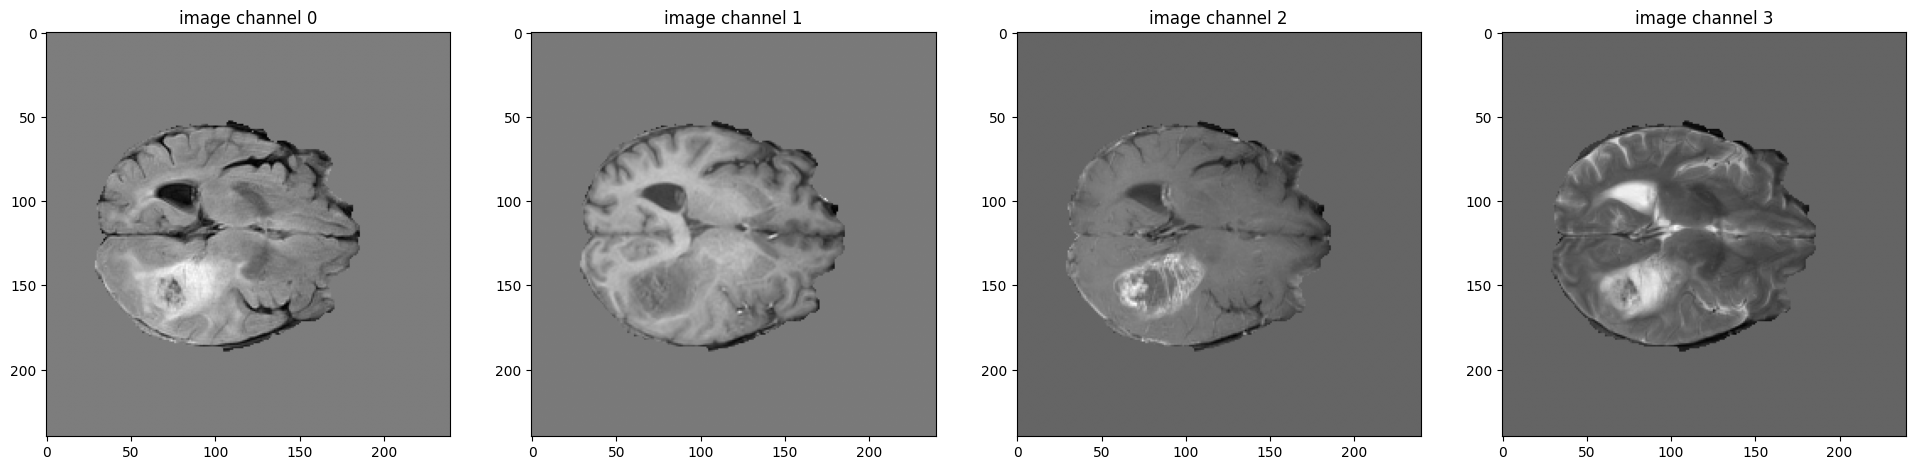

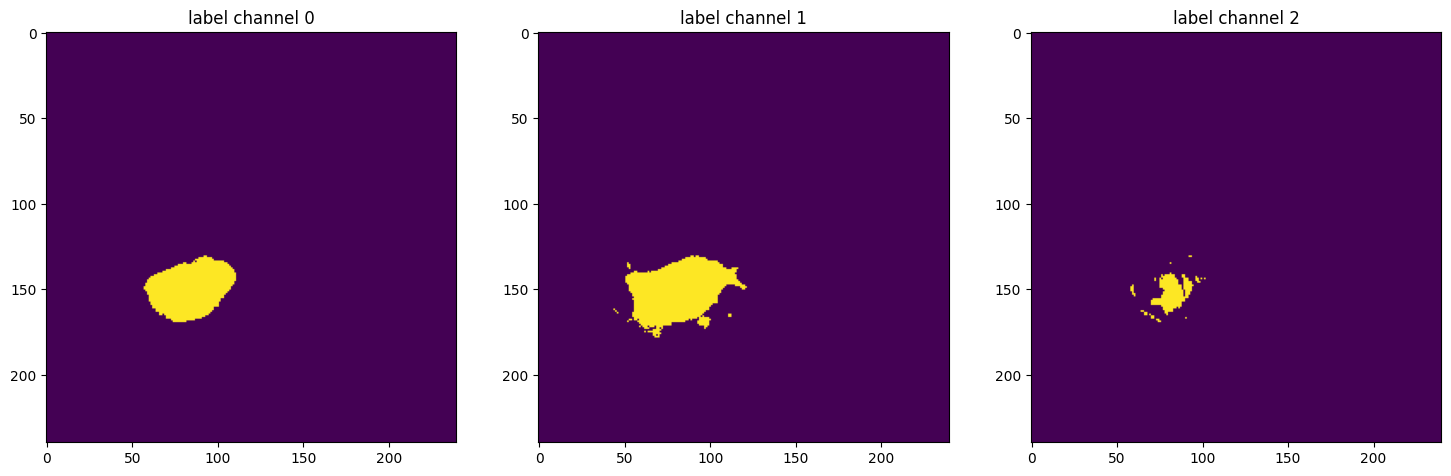

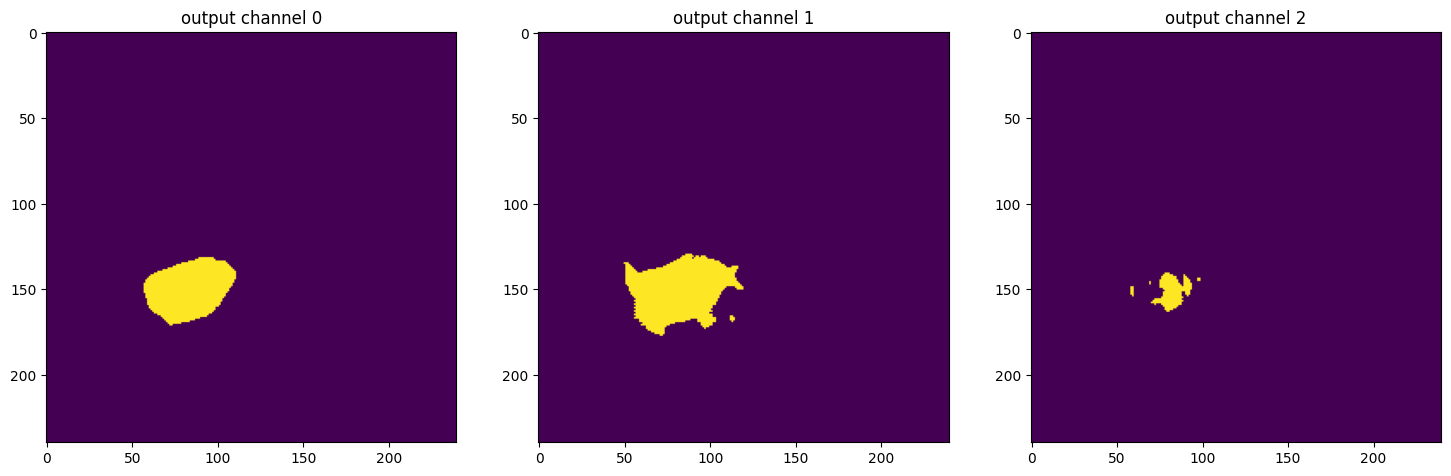

In [17]:
model.load_state_dict(torch.load(os.path.join(op_dir, "best_metric_model.pth"), weights_only=True))
model.eval()
with torch.no_grad():
    # select one image to evaluate and visualize the model output
    val_input = val_ds[6]["image"].unsqueeze(0).to(device)
    roi_size = (128, 128, 64)
    sw_batch_size = 4
    val_output = inference(val_input)
    val_output = post_trans(val_output[0])
    plt.figure("image", (24, 6))
    for i in range(4):
        plt.subplot(1, 4, i + 1)
        plt.title(f"image channel {i}")
        plt.imshow(val_ds[6]["image"][i, :, :, 70].detach().cpu(), cmap="gray")
    plt.show()
    # visualize the 3 channels label corresponding to this image
    plt.figure("label", (18, 6))
    for i in range(3):
        plt.subplot(1, 3, i + 1)
        plt.title(f"label channel {i}")
        plt.imshow(val_ds[6]["label"][i, :, :, 70].detach().cpu())
    plt.show()
    # visualize the 3 channels model output corresponding to this image
    plt.figure("output", (18, 6))
    for i in range(3):
        plt.subplot(1, 3, i + 1)
        plt.title(f"output channel {i}")
        plt.imshow(val_output[i, :, :, 70].detach().cpu())
    plt.show()

## Evaluation on original image spacings

In [18]:
!pip install -q scikit-image

import numpy as np
from skimage.measure import label as cc_label
from scipy.ndimage import binary_fill_holes
from skimage.morphology import binary_closing


In [19]:
import numpy as np
from skimage.measure import label as cc_label

def count_components(mask_np, connectivity=1):
    """
    mask_np: (D,H,W) bool/uint8
    returns: num_components, sizes(list)
    """
    if mask_np.sum() == 0:
        return 0, []
    lab = cc_label(mask_np.astype(bool), connectivity=connectivity)
    n = lab.max()
    if n == 0:
        return 0, []
    sizes = [(lab == i).sum() for i in range(1, n+1)]
    return int(n), sizes

def violation_stats(pred_np):
    """
    pred_np: (3,D,H,W) uint8/bool
    Channel order: 0=TC, 1=WT, 2=ET
    Returns dict with violation voxel counts and fractions.
    """
    tc = pred_np[0].astype(bool)
    wt = pred_np[1].astype(bool)
    et = pred_np[2].astype(bool)

    # violations
    et_out_tc = et & (~tc)
    tc_out_wt = tc & (~wt)

    # fractions defined relative to the violating class volume
    et_vol = et.sum()
    tc_vol = tc.sum()

    out = {
        "et_vol": int(et_vol),
        "tc_vol": int(tc_vol),
        "wt_vol": int(wt.sum()),
        "et_out_tc_vox": int(et_out_tc.sum()),
        "tc_out_wt_vox": int(tc_out_wt.sum()),
        "et_out_tc_frac": float(et_out_tc.sum() / (et_vol + 1e-8)) if et_vol > 0 else 0.0,
        "tc_out_wt_frac": float(tc_out_wt.sum() / (tc_vol + 1e-8)) if tc_vol > 0 else 0.0,
        "has_et_violation": bool(et_out_tc.sum() > 0),
        "has_tc_violation": bool(tc_out_wt.sum() > 0),
    }
    return out


In [20]:
def filter_small_components(pred_np, min_size=100):
    """
    Remove 3D connected components smaller than min_size voxels per class.
    pred_np: (3, D, H, W) uint8 or bool
    """
    C, D, H, W = pred_np.shape
    out = np.zeros_like(pred_np, dtype=np.uint8)

    for c in range(C):
        mask = pred_np[c].astype(bool)
        if mask.sum() == 0:
            continue

        labeled = cc_label(mask, connectivity=1)
        for comp_id in range(1, labeled.max() + 1):
            comp_mask = (labeled == comp_id)
            if comp_mask.sum() >= min_size:
                out[c][comp_mask] = 1

    return out


def enforce_hierarchy(pred_np):
    """
    Enforce ET ⊂ TC ⊂ WT.
    pred_np: (3, D, H, W) uint8 or bool
    channel 0 = TC, 1 = WT, 2 = ET
    """
    tc = pred_np[0].astype(bool)
    wt = pred_np[1].astype(bool)
    et = pred_np[2].astype(bool)

    # ET inside TC
    et = et & tc
    # TC inside WT
    tc = tc & wt
    # WT includes everything
    wt = wt | tc | et

    out = np.stack([tc, wt, et], axis=0).astype(np.uint8)
    return out


def morphology_refine(pred_np):
    """
    Simple morphology on WT (channel 1): fill holes, smooth with closing.
    pred_np: (3, D, H, W) uint8 or bool
    """
    out = pred_np.astype(bool).copy()
    wt = out[1]
    if wt.sum() > 0:
        filled = binary_fill_holes(wt)
        closed = binary_closing(filled)
        out[1] = closed
    return out.astype(np.uint8)


def intensity_guided(prob_np, th_tc=0.5, th_wt=0.5, th_et=0.6):
    """
    P4: intensity/probability-guided postprocessing via class-specific thresholds.

    prob_np: (3, D, H, W) float probabilities (after sigmoid, before threshold)
    Returns: (3, D, H, W) uint8 binary mask
    """
    tc = prob_np[0] > th_tc
    wt = prob_np[1] > th_wt
    et = prob_np[2] > th_et

    pred = np.stack([tc, wt, et], axis=0).astype(np.uint8)
    # still enforce hierarchy so ET ⊂ TC ⊂ WT
    pred = enforce_hierarchy(pred)
    return pred


def apply_postprocessing_variant(pred_tensor, prob_tensor, variant="P0", min_size=100):
    """
    Apply one of P0–P4 postprocessing variants to a *single* prediction.

    pred_tensor: (3, D, H, W) binary {0,1} tensor (after baseline post_trans)
    prob_tensor: (3, D, H, W) raw probability tensor (sigmoid outputs)
    variant: "P0" | "P1" | "P2" | "P3" | "P4"
    """
    # Convert to numpy for processing
    pred_np = pred_tensor.detach().cpu().numpy().astype(np.uint8)
    prob_np = prob_tensor.detach().cpu().numpy()

    if variant == "P0":
        # Baseline: sigmoid + fixed 0.5 threshold (already done by post_trans)
        refined_np = pred_np

    elif variant == "P1":
        # Size-based connected component filtering
        refined_np = filter_small_components(pred_np, min_size=min_size)

    elif variant == "P2":
        # Size filter + hierarchy correction
        tmp = filter_small_components(pred_np, min_size=min_size)
        refined_np = enforce_hierarchy(tmp)

    elif variant == "P3":
        # Size + hierarchy + morphological smoothing (WT)
        tmp = filter_small_components(pred_np, min_size=min_size)
        tmp = enforce_hierarchy(tmp)
        refined_np = morphology_refine(tmp)

    elif variant == "P4":
        # Intensity/probability-guided thresholds + hierarchy
        refined_np = intensity_guided(prob_np, th_tc=0.5, th_wt=0.5, th_et=0.6)

    else:
        raise ValueError(f"Unknown variant: {variant}")

    return torch.from_numpy(refined_np).to(pred_tensor.device)


In [33]:
!pip install -q scikit-image

import numpy as np
import torch
from skimage.measure import label as cc_label


In [34]:
def cc3d(mask_np, connectivity=1):
    """
    mask_np: (D,H,W) boolean or uint8
    Returns: labeled volume, dict {component_id: voxel_count}
    """
    mask = mask_np.astype(bool)
    if mask.sum() == 0:
        return None, {}

    lab = cc_label(mask, connectivity=connectivity)
    sizes = {i: int((lab == i).sum()) for i in range(1, lab.max() + 1)}
    return lab, sizes


def keep_components_by_ids(mask_np, lab, keep_ids):
    out = np.zeros_like(mask_np, dtype=np.uint8)
    for i in keep_ids:
        out[lab == i] = 1
    return out


In [35]:
def compute_case_stats(pred_np):
    """
    pred_np: (3,D,H,W) uint8 with channels [TC, WT, ET]
    """
    tc = pred_np[0].astype(bool)
    wt = pred_np[1].astype(bool)
    et = pred_np[2].astype(bool)

    et_out_tc = et & (~tc)
    tc_out_wt = tc & (~wt)

    lab_tc, sizes_tc = cc3d(tc)
    lab_wt, sizes_wt = cc3d(wt)
    lab_et, sizes_et = cc3d(et)

    return {
        "tc_cc": len(sizes_tc),
        "wt_cc": len(sizes_wt),
        "et_cc": len(sizes_et),
        "tc_vol": int(tc.sum()),
        "wt_vol": int(wt.sum()),
        "et_vol": int(et.sum()),
        "et_out_tc_vox": int(et_out_tc.sum()),
        "tc_out_wt_vox": int(tc_out_wt.sum()),
        "et_out_tc_frac": float(et_out_tc.sum() / (et.sum() + 1e-8)) if et.sum() > 0 else 0.0,
        "tc_out_wt_frac": float(tc_out_wt.sum() / (tc.sum() + 1e-8)) if tc.sum() > 0 else 0.0,
    }


In [36]:
def p2_et_hierarchy_repair(pred_np, et_out_tc_frac_thresh=0.05):
    tc = pred_np[0].astype(bool)
    wt = pred_np[1].astype(bool)
    et = pred_np[2].astype(bool)

    if et.sum() == 0 or tc.sum() == 0:
        return pred_np

    frac = (et & (~tc)).sum() / (et.sum() + 1e-8)
    if frac > et_out_tc_frac_thresh:
        et = et & tc

    return np.stack([tc, wt, et], axis=0).astype(np.uint8)


In [37]:
def p3_selective_et_prune(
    pred_np,
    min_keep_vox=25,
    max_removed_frac=0.15,
    connectivity=1
):
    tc = pred_np[0].astype(bool)
    wt = pred_np[1].astype(bool)
    et = pred_np[2].astype(bool)

    if et.sum() == 0:
        return pred_np

    lab, sizes = cc3d(et, connectivity)
    if lab is None or len(sizes) <= 1:
        return pred_np

    small_ids = [i for i, s in sizes.items() if s < min_keep_vox]
    if not small_ids:
        return pred_np

    removed_frac = sum(sizes[i] for i in small_ids) / (et.sum() + 1e-8)
    if removed_frac > max_removed_frac:
        return pred_np

    keep_ids = [i for i in sizes.keys() if i not in small_ids]
    et_new = keep_components_by_ids(et.astype(np.uint8), lab, keep_ids).astype(bool)

    return np.stack([tc, wt, et_new], axis=0).astype(np.uint8)


In [38]:
def apply_pp_v2(
    pred_bin_tensor,
    variant="P0",
    et_out_tc_frac_thresh=0.05,
    et_min_keep_vox=25,
    et_max_removed_frac=0.15,
):
    """
    Returns:
      out_tensor  (3,D,H,W)
      stats_pre   (baseline stats)
      stats_post  (stats after PP)
    """
    pred_np = pred_bin_tensor.detach().cpu().numpy().astype(np.uint8)
    stats_pre = compute_case_stats(pred_np)

    if variant in ["P0", "P1"]:
        out_np = pred_np

    elif variant == "P2":
        out_np = p2_et_hierarchy_repair(
            pred_np, et_out_tc_frac_thresh
        )

    elif variant == "P3":
        tmp = p2_et_hierarchy_repair(
            pred_np, et_out_tc_frac_thresh
        )
        out_np = p3_selective_et_prune(
            tmp,
            min_keep_vox=et_min_keep_vox,
            max_removed_frac=et_max_removed_frac,
        )

    else:
        raise ValueError(f"Unknown variant {variant}")

    stats_post = compute_case_stats(out_np)
    return torch.from_numpy(out_np).to(pred_bin_tensor.device), stats_pre, stats_post


In [39]:
variants = ["P0", "P1", "P2", "P3"]

stats_agg = {
    v: {
        "cases": 0,
        "sum_tc_cc": 0,
        "sum_wt_cc": 0,
        "sum_et_cc": 0,
        "sum_et_out_tc_frac": 0.0,
        "cases_et_violation": 0,
    }
    for v in variants
}


In [41]:
from tqdm.auto import tqdm
from monai.data.utils import decollate_batch

model.eval()

with torch.no_grad():
    for batch in tqdm(val_loader, desc="Batches", leave=True):
        imgs = batch["image"].to(device)

        probs_b = inference(imgs)
        probs_list = decollate_batch(probs_b)

        for prob in tqdm(probs_list, desc="Cases", leave=False):
            pred_bin = post_trans(prob)

            for v in tqdm(variants, desc="PP variants", leave=False):
                refined, _, st = apply_pp_v2(
                    pred_bin,
                    variant=v,
                    et_out_tc_frac_thresh=0.05,
                    et_min_keep_vox=25,
                    et_max_removed_frac=0.15,
                )

                # ---- stats aggregation ----
                stats_agg[v]["cases"] += 1
                stats_agg[v]["sum_tc_cc"] += st["tc_cc"]
                stats_agg[v]["sum_wt_cc"] += st["wt_cc"]
                stats_agg[v]["sum_et_cc"] += st["et_cc"]
                stats_agg[v]["sum_et_out_tc_frac"] += st["et_out_tc_frac"]
                stats_agg[v]["cases_et_violation"] += int(
                    st["et_out_tc_vox"] > 0 and st["et_vol"] > 0
                )


Batches:   0%|          | 0/96 [00:00<?, ?it/s]

Cases:   0%|          | 0/1 [00:00<?, ?it/s]

PP variants:   0%|          | 0/4 [00:00<?, ?it/s]

Cases:   0%|          | 0/1 [00:00<?, ?it/s]

PP variants:   0%|          | 0/4 [00:00<?, ?it/s]

Cases:   0%|          | 0/1 [00:00<?, ?it/s]

PP variants:   0%|          | 0/4 [00:00<?, ?it/s]

Cases:   0%|          | 0/1 [00:00<?, ?it/s]

PP variants:   0%|          | 0/4 [00:00<?, ?it/s]

Cases:   0%|          | 0/1 [00:00<?, ?it/s]

PP variants:   0%|          | 0/4 [00:00<?, ?it/s]

Cases:   0%|          | 0/1 [00:00<?, ?it/s]

PP variants:   0%|          | 0/4 [00:00<?, ?it/s]

Cases:   0%|          | 0/1 [00:00<?, ?it/s]

PP variants:   0%|          | 0/4 [00:00<?, ?it/s]

Cases:   0%|          | 0/1 [00:00<?, ?it/s]

PP variants:   0%|          | 0/4 [00:00<?, ?it/s]

Cases:   0%|          | 0/1 [00:00<?, ?it/s]

PP variants:   0%|          | 0/4 [00:00<?, ?it/s]

Cases:   0%|          | 0/1 [00:00<?, ?it/s]

PP variants:   0%|          | 0/4 [00:00<?, ?it/s]

Cases:   0%|          | 0/1 [00:00<?, ?it/s]

PP variants:   0%|          | 0/4 [00:00<?, ?it/s]

Cases:   0%|          | 0/1 [00:00<?, ?it/s]

PP variants:   0%|          | 0/4 [00:00<?, ?it/s]

Cases:   0%|          | 0/1 [00:00<?, ?it/s]

PP variants:   0%|          | 0/4 [00:00<?, ?it/s]

Cases:   0%|          | 0/1 [00:00<?, ?it/s]

PP variants:   0%|          | 0/4 [00:00<?, ?it/s]

Cases:   0%|          | 0/1 [00:00<?, ?it/s]

PP variants:   0%|          | 0/4 [00:00<?, ?it/s]

Cases:   0%|          | 0/1 [00:00<?, ?it/s]

PP variants:   0%|          | 0/4 [00:00<?, ?it/s]

Cases:   0%|          | 0/1 [00:00<?, ?it/s]

PP variants:   0%|          | 0/4 [00:00<?, ?it/s]

Cases:   0%|          | 0/1 [00:00<?, ?it/s]

PP variants:   0%|          | 0/4 [00:00<?, ?it/s]

Cases:   0%|          | 0/1 [00:00<?, ?it/s]

PP variants:   0%|          | 0/4 [00:00<?, ?it/s]

Cases:   0%|          | 0/1 [00:00<?, ?it/s]

PP variants:   0%|          | 0/4 [00:00<?, ?it/s]

Cases:   0%|          | 0/1 [00:00<?, ?it/s]

PP variants:   0%|          | 0/4 [00:00<?, ?it/s]

Cases:   0%|          | 0/1 [00:00<?, ?it/s]

PP variants:   0%|          | 0/4 [00:00<?, ?it/s]

Cases:   0%|          | 0/1 [00:00<?, ?it/s]

PP variants:   0%|          | 0/4 [00:00<?, ?it/s]

Cases:   0%|          | 0/1 [00:00<?, ?it/s]

PP variants:   0%|          | 0/4 [00:00<?, ?it/s]

Cases:   0%|          | 0/1 [00:00<?, ?it/s]

PP variants:   0%|          | 0/4 [00:00<?, ?it/s]

Cases:   0%|          | 0/1 [00:00<?, ?it/s]

PP variants:   0%|          | 0/4 [00:00<?, ?it/s]

Cases:   0%|          | 0/1 [00:00<?, ?it/s]

PP variants:   0%|          | 0/4 [00:00<?, ?it/s]

Cases:   0%|          | 0/1 [00:00<?, ?it/s]

PP variants:   0%|          | 0/4 [00:00<?, ?it/s]

Cases:   0%|          | 0/1 [00:00<?, ?it/s]

PP variants:   0%|          | 0/4 [00:00<?, ?it/s]

Cases:   0%|          | 0/1 [00:00<?, ?it/s]

PP variants:   0%|          | 0/4 [00:00<?, ?it/s]

Cases:   0%|          | 0/1 [00:00<?, ?it/s]

PP variants:   0%|          | 0/4 [00:00<?, ?it/s]

Cases:   0%|          | 0/1 [00:00<?, ?it/s]

PP variants:   0%|          | 0/4 [00:00<?, ?it/s]

Cases:   0%|          | 0/1 [00:00<?, ?it/s]

PP variants:   0%|          | 0/4 [00:00<?, ?it/s]

Cases:   0%|          | 0/1 [00:00<?, ?it/s]

PP variants:   0%|          | 0/4 [00:00<?, ?it/s]

Cases:   0%|          | 0/1 [00:00<?, ?it/s]

PP variants:   0%|          | 0/4 [00:00<?, ?it/s]

Cases:   0%|          | 0/1 [00:00<?, ?it/s]

PP variants:   0%|          | 0/4 [00:00<?, ?it/s]

Cases:   0%|          | 0/1 [00:00<?, ?it/s]

PP variants:   0%|          | 0/4 [00:00<?, ?it/s]

Cases:   0%|          | 0/1 [00:00<?, ?it/s]

PP variants:   0%|          | 0/4 [00:00<?, ?it/s]

Cases:   0%|          | 0/1 [00:00<?, ?it/s]

PP variants:   0%|          | 0/4 [00:00<?, ?it/s]

Cases:   0%|          | 0/1 [00:00<?, ?it/s]

PP variants:   0%|          | 0/4 [00:00<?, ?it/s]

Cases:   0%|          | 0/1 [00:00<?, ?it/s]

PP variants:   0%|          | 0/4 [00:00<?, ?it/s]

Cases:   0%|          | 0/1 [00:00<?, ?it/s]

PP variants:   0%|          | 0/4 [00:00<?, ?it/s]

Cases:   0%|          | 0/1 [00:00<?, ?it/s]

PP variants:   0%|          | 0/4 [00:00<?, ?it/s]

Cases:   0%|          | 0/1 [00:00<?, ?it/s]

PP variants:   0%|          | 0/4 [00:00<?, ?it/s]

Cases:   0%|          | 0/1 [00:00<?, ?it/s]

PP variants:   0%|          | 0/4 [00:00<?, ?it/s]

Cases:   0%|          | 0/1 [00:00<?, ?it/s]

PP variants:   0%|          | 0/4 [00:00<?, ?it/s]

Cases:   0%|          | 0/1 [00:00<?, ?it/s]

PP variants:   0%|          | 0/4 [00:00<?, ?it/s]

Cases:   0%|          | 0/1 [00:00<?, ?it/s]

PP variants:   0%|          | 0/4 [00:00<?, ?it/s]

Cases:   0%|          | 0/1 [00:00<?, ?it/s]

PP variants:   0%|          | 0/4 [00:00<?, ?it/s]

Cases:   0%|          | 0/1 [00:00<?, ?it/s]

PP variants:   0%|          | 0/4 [00:00<?, ?it/s]

Cases:   0%|          | 0/1 [00:00<?, ?it/s]

PP variants:   0%|          | 0/4 [00:00<?, ?it/s]

Cases:   0%|          | 0/1 [00:00<?, ?it/s]

PP variants:   0%|          | 0/4 [00:00<?, ?it/s]

Cases:   0%|          | 0/1 [00:00<?, ?it/s]

PP variants:   0%|          | 0/4 [00:00<?, ?it/s]

Cases:   0%|          | 0/1 [00:00<?, ?it/s]

PP variants:   0%|          | 0/4 [00:00<?, ?it/s]

Cases:   0%|          | 0/1 [00:00<?, ?it/s]

PP variants:   0%|          | 0/4 [00:00<?, ?it/s]

Cases:   0%|          | 0/1 [00:00<?, ?it/s]

PP variants:   0%|          | 0/4 [00:00<?, ?it/s]

Cases:   0%|          | 0/1 [00:00<?, ?it/s]

PP variants:   0%|          | 0/4 [00:00<?, ?it/s]

Cases:   0%|          | 0/1 [00:00<?, ?it/s]

PP variants:   0%|          | 0/4 [00:00<?, ?it/s]

Cases:   0%|          | 0/1 [00:00<?, ?it/s]

PP variants:   0%|          | 0/4 [00:00<?, ?it/s]

Cases:   0%|          | 0/1 [00:00<?, ?it/s]

PP variants:   0%|          | 0/4 [00:00<?, ?it/s]

Cases:   0%|          | 0/1 [00:00<?, ?it/s]

PP variants:   0%|          | 0/4 [00:00<?, ?it/s]

Cases:   0%|          | 0/1 [00:00<?, ?it/s]

PP variants:   0%|          | 0/4 [00:00<?, ?it/s]

Cases:   0%|          | 0/1 [00:00<?, ?it/s]

PP variants:   0%|          | 0/4 [00:00<?, ?it/s]

Cases:   0%|          | 0/1 [00:00<?, ?it/s]

PP variants:   0%|          | 0/4 [00:00<?, ?it/s]

Cases:   0%|          | 0/1 [00:00<?, ?it/s]

PP variants:   0%|          | 0/4 [00:00<?, ?it/s]

Cases:   0%|          | 0/1 [00:00<?, ?it/s]

PP variants:   0%|          | 0/4 [00:00<?, ?it/s]

Cases:   0%|          | 0/1 [00:00<?, ?it/s]

PP variants:   0%|          | 0/4 [00:00<?, ?it/s]

Cases:   0%|          | 0/1 [00:00<?, ?it/s]

PP variants:   0%|          | 0/4 [00:00<?, ?it/s]

Cases:   0%|          | 0/1 [00:00<?, ?it/s]

PP variants:   0%|          | 0/4 [00:00<?, ?it/s]

Cases:   0%|          | 0/1 [00:00<?, ?it/s]

PP variants:   0%|          | 0/4 [00:00<?, ?it/s]

Cases:   0%|          | 0/1 [00:00<?, ?it/s]

PP variants:   0%|          | 0/4 [00:00<?, ?it/s]

Cases:   0%|          | 0/1 [00:00<?, ?it/s]

PP variants:   0%|          | 0/4 [00:00<?, ?it/s]

Cases:   0%|          | 0/1 [00:00<?, ?it/s]

PP variants:   0%|          | 0/4 [00:00<?, ?it/s]

Cases:   0%|          | 0/1 [00:00<?, ?it/s]

PP variants:   0%|          | 0/4 [00:00<?, ?it/s]

Cases:   0%|          | 0/1 [00:00<?, ?it/s]

PP variants:   0%|          | 0/4 [00:00<?, ?it/s]

Cases:   0%|          | 0/1 [00:00<?, ?it/s]

PP variants:   0%|          | 0/4 [00:00<?, ?it/s]

Cases:   0%|          | 0/1 [00:00<?, ?it/s]

PP variants:   0%|          | 0/4 [00:00<?, ?it/s]

Cases:   0%|          | 0/1 [00:00<?, ?it/s]

PP variants:   0%|          | 0/4 [00:00<?, ?it/s]

Cases:   0%|          | 0/1 [00:00<?, ?it/s]

PP variants:   0%|          | 0/4 [00:00<?, ?it/s]

Cases:   0%|          | 0/1 [00:00<?, ?it/s]

PP variants:   0%|          | 0/4 [00:00<?, ?it/s]

Cases:   0%|          | 0/1 [00:00<?, ?it/s]

PP variants:   0%|          | 0/4 [00:00<?, ?it/s]

Cases:   0%|          | 0/1 [00:00<?, ?it/s]

PP variants:   0%|          | 0/4 [00:00<?, ?it/s]

Cases:   0%|          | 0/1 [00:00<?, ?it/s]

PP variants:   0%|          | 0/4 [00:00<?, ?it/s]

Cases:   0%|          | 0/1 [00:00<?, ?it/s]

PP variants:   0%|          | 0/4 [00:00<?, ?it/s]

Cases:   0%|          | 0/1 [00:00<?, ?it/s]

PP variants:   0%|          | 0/4 [00:00<?, ?it/s]

Cases:   0%|          | 0/1 [00:00<?, ?it/s]

PP variants:   0%|          | 0/4 [00:00<?, ?it/s]

Cases:   0%|          | 0/1 [00:00<?, ?it/s]

PP variants:   0%|          | 0/4 [00:00<?, ?it/s]

Cases:   0%|          | 0/1 [00:00<?, ?it/s]

PP variants:   0%|          | 0/4 [00:00<?, ?it/s]

Cases:   0%|          | 0/1 [00:00<?, ?it/s]

PP variants:   0%|          | 0/4 [00:00<?, ?it/s]

Cases:   0%|          | 0/1 [00:00<?, ?it/s]

PP variants:   0%|          | 0/4 [00:00<?, ?it/s]

Cases:   0%|          | 0/1 [00:00<?, ?it/s]

PP variants:   0%|          | 0/4 [00:00<?, ?it/s]

Cases:   0%|          | 0/1 [00:00<?, ?it/s]

PP variants:   0%|          | 0/4 [00:00<?, ?it/s]

Cases:   0%|          | 0/1 [00:00<?, ?it/s]

PP variants:   0%|          | 0/4 [00:00<?, ?it/s]

Cases:   0%|          | 0/1 [00:00<?, ?it/s]

PP variants:   0%|          | 0/4 [00:00<?, ?it/s]

Cases:   0%|          | 0/1 [00:00<?, ?it/s]

PP variants:   0%|          | 0/4 [00:00<?, ?it/s]

Cases:   0%|          | 0/1 [00:00<?, ?it/s]

PP variants:   0%|          | 0/4 [00:00<?, ?it/s]

In [42]:
print("\n================= POSTPROCESS STATS (P0–P3) =================")
for v in variants:
    n = stats_agg[v]["cases"]
    print(f"\n--- {v} ---")
    print(f"Cases: {n}")
    print(f"Mean CC: TC={stats_agg[v]['sum_tc_cc']/n:.2f}, "
          f"WT={stats_agg[v]['sum_wt_cc']/n:.2f}, "
          f"ET={stats_agg[v]['sum_et_cc']/n:.2f}")
    print(f"ET⊄TC violation rate: "
          f"{100*stats_agg[v]['cases_et_violation']/n:.1f}%")
    print(f"Mean ET_out_TC_frac: "
          f"{stats_agg[v]['sum_et_out_tc_frac']/n:.4f}")



================= POSTPROCESS STATS (P0–P3) =================

--- P0 ---
Cases: 103
Mean CC: TC=12.63, WT=11.19, ET=31.48
ET⊄TC violation rate: 99.0%
Mean ET_out_TC_frac: 0.0538

--- P1 ---
Cases: 103
Mean CC: TC=12.63, WT=11.19, ET=31.48
ET⊄TC violation rate: 99.0%
Mean ET_out_TC_frac: 0.0538

--- P2 ---
Cases: 102
Mean CC: TC=12.71, WT=11.26, ET=32.81
ET⊄TC violation rate: 59.8%
Mean ET_out_TC_frac: 0.0101

--- P3 ---
Cases: 102
Mean CC: TC=12.71, WT=11.26, ET=3.63
ET⊄TC violation rate: 58.8%
Mean ET_out_TC_frac: 0.0101


In [48]:
from tqdm.auto import tqdm
import torch
import numpy as np
from monai.metrics import DiceMetric, HausdorffDistanceMetric, SurfaceDiceMetric
from monai.data.utils import decollate_batch


In [57]:
import numpy as np
import torch
from skimage.measure import label as cc_label
from scipy.ndimage import binary_dilation, gaussian_filter

def build_support(tc_bin, wt_bin, dilate_iters=2):
    # ET should be near tumor core and within WT
    tc_dil = binary_dilation(tc_bin.astype(bool), iterations=dilate_iters)
    return (tc_dil & wt_bin.astype(bool))

def hysteresis_et(et_prob, support, t_high=0.65, t_low=0.35, connectivity=1):
    seeds = (et_prob >= t_high) & support
    grow  = (et_prob >= t_low) & support
    if seeds.sum() == 0:
        return np.zeros_like(et_prob, dtype=np.uint8)

    lab = cc_label(grow.astype(bool), connectivity=connectivity)
    seed_ids = np.unique(lab[seeds])
    seed_ids = seed_ids[seed_ids != 0]
    return np.isin(lab, seed_ids).astype(np.uint8)

def score_filter_components(et_bin, et_prob, support, min_score=0.30, w_prob=0.8, w_sup=0.2):
    et_bin = et_bin.astype(bool)
    if et_bin.sum() == 0:
        return et_bin.astype(np.uint8)

    lab = cc_label(et_bin, connectivity=1)
    n = lab.max()
    if n <= 1:
        return et_bin.astype(np.uint8)

    keep = []
    for cid in range(1, n + 1):
        m = (lab == cid)
        if m.sum() == 0:
            continue
        mean_p = float(et_prob[m].mean())
        sup_frac = float(support[m].mean())
        score = w_prob * mean_p + w_sup * sup_frac
        if score >= min_score:
            keep.append(cid)

    return np.isin(lab, keep).astype(np.uint8)

def smooth_prob(prob, sigma=0.7):
    # light smoothing to reduce jaggedness/speckle in probability space
    return gaussian_filter(prob, sigma=sigma)


In [45]:
def precision_recall_per_class(pred, gt, eps=1e-8):
    """
    pred, gt: (3,D,H,W) binary {0,1} torch tensors
    returns precision, recall tensors shape (3,)
    """
    pred = pred.float()
    gt = gt.float()
    tp = (pred * gt).sum(dim=(1,2,3))
    fp = (pred * (1 - gt)).sum(dim=(1,2,3))
    fn = ((1 - pred) * gt).sum(dim=(1,2,3))
    precision = tp / (tp + fp + eps)
    recall    = tp / (tp + fn + eps)
    return precision, recall


In [50]:
# aggregate precision/recall
pr_agg = {v: {"n":0, "prec_sum":torch.zeros(3), "rec_sum":torch.zeros(3)} for v in variants}

model.eval()
with torch.no_grad():
    for batch in tqdm(val_loader, desc="Eval (Dice+HD95+SurfaceDice+PR)"):
        imgs = batch["image"].to(device)
        labs = batch["label"].to(device)

        probs_b = inference(imgs)  # (B,3,D,H,W)
        prob_list = decollate_batch(probs_b)
        lab_list  = decollate_batch(labs)

        for prob, lab in zip(prob_list, lab_list):
            pred_bin = post_trans(prob)  # (3,D,H,W) binary baseline

            # build variant outputs
            outputs = {}
            outputs["P0"] = pred_bin

            out_p2, _, _ = apply_pp_v2(pred_bin, variant="P2",
                                       et_out_tc_frac_thresh=0.05,
                                       et_min_keep_vox=25,
                                       et_max_removed_frac=0.15)
            outputs["P2"] = out_p2

            out_p3, _, _ = apply_pp_v2(pred_bin, variant="P3",
                                       et_out_tc_frac_thresh=0.05,
                                       et_min_keep_vox=25,
                                       et_max_removed_frac=0.15)
            outputs["P3"] = out_p3

            # metrics expect (B,C,D,H,W)
            lab_t = lab.float().unsqueeze(0)

            for v in variants:
                pred_t = outputs[v].float().unsqueeze(0)

                dice_mean[v](y_pred=pred_t, y=lab_t)
                dice_pc[v](y_pred=pred_t, y=lab_t)

                hd95_pc[v](y_pred=pred_t, y=lab_t)
                surf_pc[v](y_pred=pred_t, y=lab_t)

                prec, rec = precision_recall_per_class(outputs[v], lab)
                pr_agg[v]["prec_sum"] += prec.cpu()
                pr_agg[v]["rec_sum"]  += rec.cpu()
                pr_agg[v]["n"] += 1


Eval (Dice+HD95+SurfaceDice+PR):   0%|          | 0/96 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/monai/utils/deprecate_utils.py:221: FutureWarning: monai.metrics.utils get_mask_edges:always_return_as_numpy: Argument `always_return_as_numpy` has been deprecated since version 1.5.0. It will be removed in version 1.7.0. The option is removed and the return type will always be equal to the input type.
  warn_deprecated(argname, msg, warning_category)


In [51]:
labels = ["TC","WT","ET"]

print("\n================= METRICS COMPARISON =================")
for v in variants:
    mean_d = dice_mean[v].aggregate().item()
    pc_d   = dice_pc[v].aggregate().cpu()          # (3,)
    pc_hd  = hd95_pc[v].aggregate().cpu()          # (3,)
    pc_sd  = surf_pc[v].aggregate().cpu()          # (3,)

    dice_mean[v].reset(); dice_pc[v].reset()
    hd95_pc[v].reset(); surf_pc[v].reset()

    n = pr_agg[v]["n"]
    prec = (pr_agg[v]["prec_sum"] / max(n,1)).numpy()
    rec  = (pr_agg[v]["rec_sum"]  / max(n,1)).numpy()

    print(f"\n--- {v} ---")
    print(f"Mean Dice: {mean_d:.4f}")
    for i, name in enumerate(labels):
        print(f"{name}: Dice={pc_d[i]:.4f} | HD95={pc_hd[i]:.2f} | SurfDice@2mm={pc_sd[i]:.4f} | Prec={prec[i]:.4f} | Rec={rec[i]:.4f}")



================= METRICS COMPARISON =================

--- P0 ---
Mean Dice: 0.7512
TC: Dice=0.7975 | HD95=9.80 | SurfDice@2mm=0.7448 | Prec=0.7891 | Rec=0.8456
WT: Dice=0.9003 | HD95=8.04 | SurfDice@2mm=0.8537 | Prec=0.8911 | Rec=0.9177
ET: Dice=0.5557 | HD95=10.50 | SurfDice@2mm=0.6925 | Prec=0.5897 | Rec=0.5873

--- P2 ---
Mean Dice: 0.7491
TC: Dice=0.7975 | HD95=9.80 | SurfDice@2mm=0.7448 | Prec=0.7891 | Rec=0.8456
WT: Dice=0.9003 | HD95=8.04 | SurfDice@2mm=0.8537 | Prec=0.8911 | Rec=0.9177
ET: Dice=0.5494 | HD95=10.54 | SurfDice@2mm=0.6920 | Prec=0.5941 | Rec=0.5717

--- P3 ---
Mean Dice: 0.7489
TC: Dice=0.7975 | HD95=9.80 | SurfDice@2mm=0.7448 | Prec=0.7891 | Rec=0.8456
WT: Dice=0.9003 | HD95=8.04 | SurfDice@2mm=0.8537 | Prec=0.8911 | Rec=0.9177
ET: Dice=0.5489 | HD95=11.41 | SurfDice@2mm=0.6822 | Prec=0.5954 | Rec=0.5693


In [58]:
import numpy as np
import torch
from skimage.measure import label as cc_label
from scipy.ndimage import binary_dilation, gaussian_filter

def build_support(tc_bin, wt_bin, dilate_iters=2):
    # ET should be near tumor core and within WT
    tc_dil = binary_dilation(tc_bin.astype(bool), iterations=dilate_iters)
    return (tc_dil & wt_bin.astype(bool))

def hysteresis_et(et_prob, support, t_high=0.65, t_low=0.35, connectivity=1):
    seeds = (et_prob >= t_high) & support
    grow  = (et_prob >= t_low) & support
    if seeds.sum() == 0:
        return np.zeros_like(et_prob, dtype=np.uint8)

    lab = cc_label(grow.astype(bool), connectivity=connectivity)
    seed_ids = np.unique(lab[seeds])
    seed_ids = seed_ids[seed_ids != 0]
    return np.isin(lab, seed_ids).astype(np.uint8)

def score_filter_components(et_bin, et_prob, support, min_score=0.30, w_prob=0.8, w_sup=0.2):
    et_bin = et_bin.astype(bool)
    if et_bin.sum() == 0:
        return et_bin.astype(np.uint8)

    lab = cc_label(et_bin, connectivity=1)
    n = lab.max()
    if n <= 1:
        return et_bin.astype(np.uint8)

    keep = []
    for cid in range(1, n + 1):
        m = (lab == cid)
        if m.sum() == 0:
            continue
        mean_p = float(et_prob[m].mean())
        sup_frac = float(support[m].mean())
        score = w_prob * mean_p + w_sup * sup_frac
        if score >= min_score:
            keep.append(cid)

    return np.isin(lab, keep).astype(np.uint8)

def smooth_prob(prob, sigma=0.7):
    # light smoothing to reduce jaggedness/speckle in probability space
    return gaussian_filter(prob, sigma=sigma)


In [60]:
def apply_pp_p0_p4(pred_bin_tensor, prob_tensor, variant="P0",
                   t_tc=0.50, t_wt=0.50, t_et=0.50,
                   dilate_iters=2,
                   t_high=0.65, t_low=0.35,
                   min_score=0.30,
                   smooth_sigma=0.7):
    """
    pred_bin_tensor: (3,D,H,W) baseline binarized (can ignore for some variants)
    prob_tensor: (3,D,H,W) logits from model (preferred). We'll sigmoid it.
    channels: 0=TC, 1=WT, 2=ET
    """
    device = pred_bin_tensor.device
    prob = torch.sigmoid(prob_tensor.detach()).cpu().numpy()  # (3,D,H,W) in [0,1]

    tc_prob = prob[0]
    wt_prob = prob[1]
    et_prob = prob[2]

    if variant == "P0":
        tc = (tc_prob >= 0.50)
        wt = (wt_prob >= 0.50)
        et = (et_prob >= 0.50)

    elif variant == "P1":
        # calibrated thresholds per class
        tc = (tc_prob >= t_tc)
        wt = (wt_prob >= t_wt)
        et = (et_prob >= t_et)

    elif variant == "P2":
        tc = (tc_prob >= t_tc)
        wt = (wt_prob >= t_wt)
        support = build_support(tc, wt, dilate_iters=dilate_iters)
        et = hysteresis_et(et_prob, support, t_high=t_high, t_low=t_low).astype(bool)

    elif variant == "P3":
        tc = (tc_prob >= t_tc)
        wt = (wt_prob >= t_wt)
        support = build_support(tc, wt, dilate_iters=dilate_iters)
        et0 = hysteresis_et(et_prob, support, t_high=t_high, t_low=t_low).astype(bool)
        et = score_filter_components(et0, et_prob, support, min_score=min_score).astype(bool)

    elif variant == "P4":
        tc = (tc_prob >= t_tc)
        wt = (wt_prob >= t_wt)
        support = build_support(tc, wt, dilate_iters=dilate_iters)

        et_prob_s = smooth_prob(et_prob, sigma=smooth_sigma)
        et0 = hysteresis_et(et_prob_s, support, t_high=t_high, t_low=t_low).astype(bool)
        et = score_filter_components(et0, et_prob_s, support, min_score=min_score).astype(bool)

    else:
        raise ValueError(f"Unknown variant: {variant}")

    # enforce hierarchy gently (safe, low impact)
    wt = wt | tc  # TC should be inside WT; union avoids TC_out_WT errors
    et = et & wt  # ET cannot exist outside WT

    out = np.stack([tc.astype(np.uint8), wt.astype(np.uint8), et.astype(np.uint8)], axis=0)
    return torch.from_numpy(out).to(device)


In [62]:
from tqdm.auto import tqdm
import torch
import numpy as np

from monai.metrics import DiceMetric, HausdorffDistanceMetric, SurfaceDiceMetric
from monai.data.utils import decollate_batch

# P0–P4 variants
variants = ["P0", "P1", "P2", "P3", "P4"]

# Metrics
dice_mean = {v: DiceMetric(include_background=True, reduction="mean") for v in variants}
dice_pc   = {v: DiceMetric(include_background=True, reduction="mean_batch") for v in variants}

hd95_pc   = {v: HausdorffDistanceMetric(include_background=True, reduction="mean_batch", percentile=95) for v in variants}

# surface dice at 2mm for each class (TC, WT, ET)
surf_pc   = {v: SurfaceDiceMetric(include_background=True, reduction="mean_batch",
                                  class_thresholds=[2.0, 2.0, 2.0]) for v in variants}

def precision_recall_per_class(pred, gt, eps=1e-8):
    """
    pred, gt: (3,D,H,W) binary torch tensors
    returns precision, recall: shape (3,)
    """
    pred = pred.float()
    gt   = gt.float()
    tp = (pred * gt).sum(dim=(1,2,3))
    fp = (pred * (1 - gt)).sum(dim=(1,2,3))
    fn = ((1 - pred) * gt).sum(dim=(1,2,3))
    precision = tp / (tp + fp + eps)
    recall    = tp / (tp + fn + eps)
    return precision, recall


In [63]:
cfg = dict(
    # P1 thresholds (start near baseline)
    t_tc=0.50, t_wt=0.50, t_et=0.50,

    # support + hysteresis
    dilate_iters=2,
    t_high=0.65, t_low=0.35,

    # component scoring
    min_score=0.30,

    # probability smoothing (P4)
    smooth_sigma=0.7
)


In [66]:
import gc, torch
gc.collect()
torch.cuda.empty_cache()


In [67]:
def inference_eval(inputs: torch.Tensor) -> torch.Tensor:
    # smaller ROI + lower overlap + sw_batch_size=1 reduces memory a lot
    roi = (160, 160, 96)          # smaller than (240,240,160)
    overlap = 0.25                # 0.5 is expensive
    sw_bs = 1

    if torch.cuda.is_available():
        from torch.amp import autocast
        with autocast("cuda", dtype=torch.float16):
            return sliding_window_inference(
                inputs=inputs, roi_size=roi, sw_batch_size=sw_bs,
                predictor=model, overlap=overlap
            )
    else:
        return sliding_window_inference(
            inputs=inputs, roi_size=roi, sw_batch_size=sw_bs,
            predictor=model, overlap=overlap
        )


In [68]:
# PR aggregation
pr_agg = {v: {"n": 0, "prec_sum": torch.zeros(3), "rec_sum": torch.zeros(3)} for v in variants}

model.eval()
with torch.no_grad():
    for batch in tqdm(val_loader, desc="Eval P0–P4 (Dice/HD95/SurfDice/PR)"):
        imgs = batch["image"].to(device)
        labs = batch["label"].to(device)

        logits_b = inference(imgs)  # (B,3,D,H,W) logits
        log_list = decollate_batch(logits_b)
        lab_list = decollate_batch(labs)

        for logit, lab in zip(log_list, lab_list):
            # We build P0–P4 from logits (probability-aware), NOT from thresholded masks.
            # pred_bin_tensor is unused for most variants; we just pass a placeholder.
            dummy_pred_bin = torch.zeros_like(logit).to(device)

            outs = {}
            for v in variants:
                outs[v] = apply_pp_p0_p4(
                    pred_bin_tensor=dummy_pred_bin,
                    prob_tensor=logit,
                    variant=v,
                    **cfg
                )

            # MONAI metrics expect (B,C,D,H,W)
            lab_t = lab.float().unsqueeze(0)

            for v in variants:
                pred_t = outs[v].float().unsqueeze(0)

                dice_mean[v](y_pred=pred_t, y=lab_t)
                dice_pc[v](y_pred=pred_t, y=lab_t)

                hd95_pc[v](y_pred=pred_t, y=lab_t)
                surf_pc[v](y_pred=pred_t, y=lab_t)

                prec, rec = precision_recall_per_class(outs[v].cpu(), lab.cpu())
                pr_agg[v]["prec_sum"] += prec
                pr_agg[v]["rec_sum"]  += rec
                pr_agg[v]["n"] += 1

Eval P0–P4 (Dice/HD95/SurfDice/PR):   0%|          | 0/96 [00:00<?, ?it/s]

In [69]:
labels = ["TC", "WT", "ET"]

print("\n================= METRICS COMPARISON (P0–P4) =================")
for v in variants:
    mean_d = dice_mean[v].aggregate().item()
    pc_d   = dice_pc[v].aggregate().cpu()
    pc_hd  = hd95_pc[v].aggregate().cpu()
    pc_sd  = surf_pc[v].aggregate().cpu()

    dice_mean[v].reset(); dice_pc[v].reset()
    hd95_pc[v].reset(); surf_pc[v].reset()

    n = max(pr_agg[v]["n"], 1)
    prec = (pr_agg[v]["prec_sum"] / n).numpy()
    rec  = (pr_agg[v]["rec_sum"]  / n).numpy()

    print(f"\n--- {v} ---")
    print(f"Mean Dice: {mean_d:.4f}")
    for i, name in enumerate(labels):
        print(f"{name}: Dice={pc_d[i]:.4f} | HD95={pc_hd[i]:.2f} | SurfDice@2mm={pc_sd[i]:.4f} | Prec={prec[i]:.4f} | Rec={rec[i]:.4f}")



================= METRICS COMPARISON (P0–P4) =================

--- P0 ---
Mean Dice: 0.7500
TC: Dice=0.7937 | HD95=10.11 | SurfDice@2mm=0.7433 | Prec=0.7891 | Rec=0.8456
WT: Dice=0.8983 | HD95=8.06 | SurfDice@2mm=0.8534 | Prec=0.8909 | Rec=0.9184
ET: Dice=0.5580 | HD95=10.80 | SurfDice@2mm=0.6961 | Prec=0.5897 | Rec=0.5873

--- P1 ---
Mean Dice: 0.7500
TC: Dice=0.7937 | HD95=10.11 | SurfDice@2mm=0.7433 | Prec=0.7891 | Rec=0.8456
WT: Dice=0.8983 | HD95=8.06 | SurfDice@2mm=0.8534 | Prec=0.8909 | Rec=0.9184
ET: Dice=0.5580 | HD95=10.80 | SurfDice@2mm=0.6961 | Prec=0.5897 | Rec=0.5873

--- P2 ---
Mean Dice: 0.7492
TC: Dice=0.7937 | HD95=10.11 | SurfDice@2mm=0.7433 | Prec=0.7891 | Rec=0.8456
WT: Dice=0.8983 | HD95=8.06 | SurfDice@2mm=0.8534 | Prec=0.8909 | Rec=0.9184
ET: Dice=0.5556 | HD95=10.80 | SurfDice@2mm=0.7144 | Prec=0.5138 | Rec=0.6922

--- P3 ---
Mean Dice: 0.7492
TC: Dice=0.7937 | HD95=10.11 | SurfDice@2mm=0.7433 | Prec=0.7891 | Rec=0.8456
WT: Dice=0.8983 | HD95=8.06 | SurfDice@

In [70]:
pr_tot = {v: {"tp": torch.zeros(3), "fp": torch.zeros(3), "fn": torch.zeros(3)} for v in variants}

def accumulate_tp_fp_fn(pred, gt, store):
    pred = pred.float()
    gt   = gt.float()
    tp = (pred * gt).sum(dim=(1,2,3)).cpu()
    fp = (pred * (1 - gt)).sum(dim=(1,2,3)).cpu()
    fn = ((1 - pred) * gt).sum(dim=(1,2,3)).cpu()
    store["tp"] += tp
    store["fp"] += fp
    store["fn"] += fn


In [71]:
prec = pr_tot[v]["tp"] / (pr_tot[v]["tp"] + pr_tot[v]["fp"] + 1e-8)
rec  = pr_tot[v]["tp"] / (pr_tot[v]["tp"] + pr_tot[v]["fn"] + 1e-8)


In [72]:
# global tp/fp/fn aggregation
if "pr_tot" not in globals():
    pr_tot = {vv: {"tp": torch.zeros(3), "fp": torch.zeros(3), "fn": torch.zeros(3)} for vv in variants}

def acc(pred, gt, store):
    pred = pred.float()
    gt = gt.float()
    store["tp"] += (pred*gt).sum(dim=(1,2,3)).cpu()
    store["fp"] += (pred*(1-gt)).sum(dim=(1,2,3)).cpu()
    store["fn"] += ((1-pred)*gt).sum(dim=(1,2,3)).cpu()

# also collect ET voxel count and ET CC
if "et_stats" not in globals():
    et_stats = {vv: {"n":0, "et_vox_sum":0, "et_cc_sum":0} for vv in variants}

from skimage.measure import label as cc_label
def et_cc(mask3):
    et = mask3[2].cpu().numpy().astype(bool)
    lab = cc_label(et, connectivity=1)
    return lab.max(), int(et.sum())

for v in variants:
    acc(outs[v].cpu(), lab.cpu(), pr_tot[v])
    cc, vox = et_cc(outs[v])
    et_stats[v]["n"] += 1
    et_stats[v]["et_vox_sum"] += vox
    et_stats[v]["et_cc_sum"] += cc


In [73]:
print("\n==== GLOBAL PREC/REC + ET CC/Volume ====")
for v in variants:
    tp = pr_tot[v]["tp"]; fp = pr_tot[v]["fp"]; fn = pr_tot[v]["fn"]
    prec = tp/(tp+fp+1e-8)
    rec  = tp/(tp+fn+1e-8)

    n = et_stats[v]["n"]
    mean_et_vox = et_stats[v]["et_vox_sum"]/max(n,1)
    mean_et_cc  = et_stats[v]["et_cc_sum"]/max(n,1)

    print(f"{v}: Prec={prec.numpy()} | Rec={rec.numpy()} | mean_ET_vox={mean_et_vox:.1f} | mean_ET_CC={mean_et_cc:.2f}")



==== GLOBAL PREC/REC + ET CC/Volume ====
P0: Prec=[0.9460603 0.9491684 0.9543037] | Rec=[0.95642114 0.8996932  0.87083995] | mean_ET_vox=18426.0 | mean_ET_CC=8.00
P1: Prec=[0.9460603 0.9491684 0.9543037] | Rec=[0.95642114 0.8996932  0.87083995] | mean_ET_vox=18426.0 | mean_ET_CC=8.00
P2: Prec=[0.9460603 0.9491684 0.9395753] | Rec=[0.95642114 0.8996932  0.89406693] | mean_ET_vox=19214.0 | mean_ET_CC=1.00
P3: Prec=[0.9460603 0.9491684 0.9395753] | Rec=[0.95642114 0.8996932  0.89406693] | mean_ET_vox=19214.0 | mean_ET_CC=1.00
P4: Prec=[0.9460603  0.9491684  0.92715836] | Rec=[0.95642114 0.8996932  0.90520996] | mean_ET_vox=19714.0 | mean_ET_CC=1.00
